In [1]:
import pandas as pd
import numpy as np
import heapq
import sys
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn import model_selection

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
df_19 = pd.read_csv('crimedata_csv_AllNeighbourhoods_2019.csv')
df_20 = pd.read_csv('crimedata_csv_AllNeighbourhoods_2020.csv')
df_21 = pd.read_csv('crimedata_csv_AllNeighbourhoods_2021.csv')
df_22=pd.read_csv('crimedata_csv_AllNeighbourhoods_2022.csv')

In [3]:
merged_df = pd.concat([df_19, df_20, df_21,df_22])

In [4]:
merged_df.sample(5)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
43289,Other Theft,2019,7,20,22,0,2XX E 13TH AVE,Mount Pleasant,492791.6682,5.456280e+06
36122,Other Theft,2020,3,11,20,1,4XX SW MARINE DR,Marpole,491549.9513,5.450858e+06
26975,Mischief,2020,2,18,16,16,RICHARDS ST / W PENDER ST,Central Business District,491791.7544,5.458969e+06
3909,Theft from Vehicle,2020,1,31,1,30,17XX E 47TH AVE,Victoria-Fraserview,494846.8452,5.452764e+06
16689,Theft from Vehicle,2019,8,11,13,0,8XX SEYMOUR ST,Central Business District,491322.5404,5.458639e+06


In [5]:
merged_df.columns

Index(['TYPE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK',
       'NEIGHBOURHOOD', 'X', 'Y'],
      dtype='object')

In [6]:
merged_df.shape

(152066, 10)

(137131, 10)

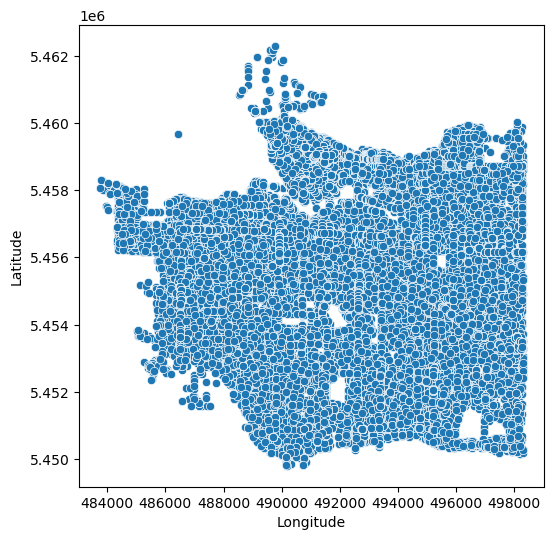

In [7]:
df1=merged_df.copy()
df1=df1.rename(columns={'X':'Longitude','Y':'Latitude'})
df1=df1[(df1['Longitude']<500000) & (df1['Latitude']>300000)]
plt.figure(figsize=(6,6))
ax=sns.scatterplot(x='Longitude',y='Latitude', data=df1)
df1.shape

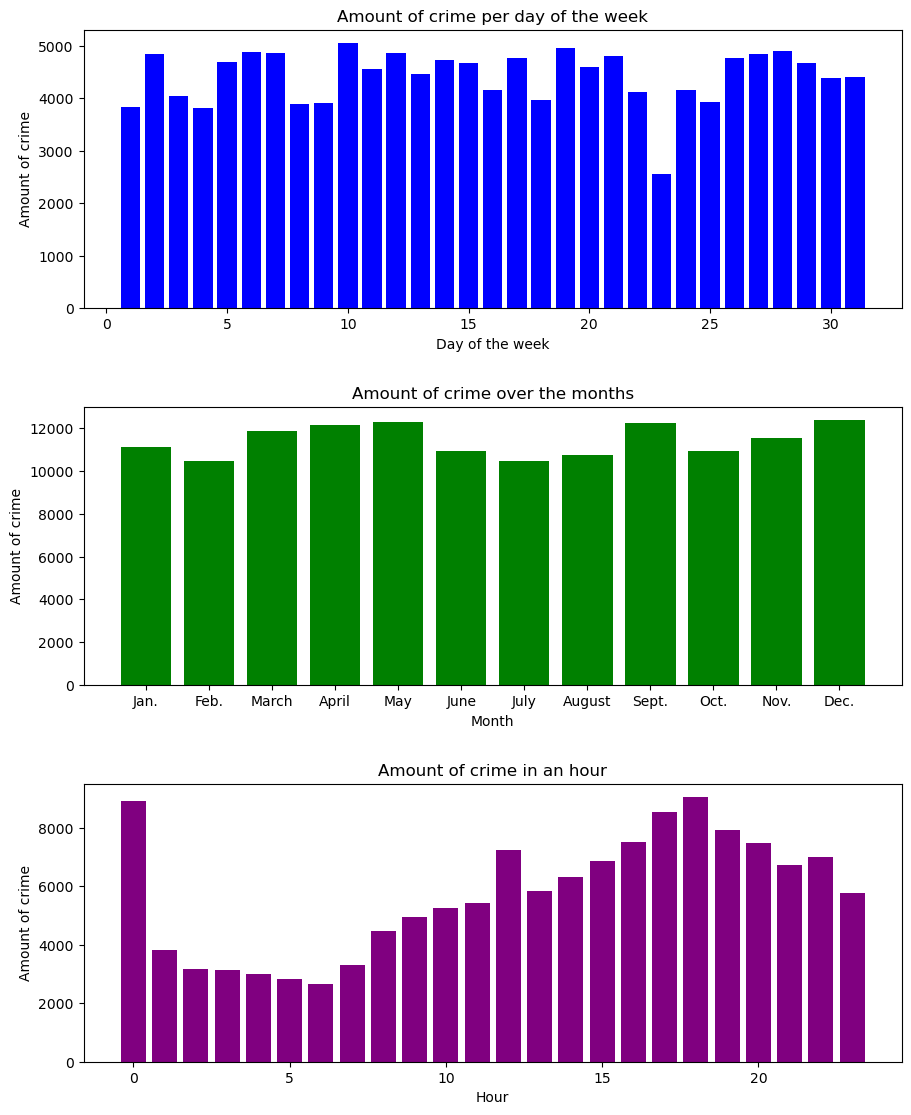

In [8]:
fig, (ax2, ax3, ax4) = plt.subplots(3, 1, figsize=(10, 12))
fig.tight_layout(pad=5.0)


count = Counter(df1['DAY'])
ax2.bar(np.unique(df1['DAY']), count.values(), color='blue')
ax2.set_title('Amount of crime per day of the week')
ax2.set_ylabel('Amount of crime')
ax2.set_xlabel('Day of the week')

count = Counter(df1['MONTH'])
ax3.bar(['Jan.', 'Feb.', 'March', 'April', 'May', 'June', 'July', 'August','Sept.','Oct.','Nov.','Dec.'],count.values(),color='green')
ax3.set_title('Amount of crime over the months')
ax3.set_ylabel('Amount of crime')
ax3.set_xlabel('Month')

count = Counter(df1['HOUR'])
ax4.bar(count.keys(), count.values(), color='purple')
ax4.set_title('Amount of crime in an hour')
ax4.set_ylabel('Amount of crime')
ax4.set_xlabel('Hour')


plt.show()

In [9]:
# Using pandas value_counts function to aggregate types
df1['TYPE'].value_counts().sort_index()

Break and Enter Commercial                                 9341
Break and Enter Residential/Other                          7107
Mischief                                                  22955
Other Theft                                               40281
Theft from Vehicle                                        42198
Theft of Bicycle                                           7186
Theft of Vehicle                                           3982
Vehicle Collision or Pedestrian Struck (with Fatality)       60
Vehicle Collision or Pedestrian Struck (with Injury)       4021
Name: TYPE, dtype: int64

In [10]:
df2=df1.copy()

In [11]:
df2.sample(5)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,Longitude,Latitude
24711,Mischief,2020,11,27,20,38,55XX HIGHBURY ST,Dunbar-Southlands,486288.9918,5.453699e+06
10436,Theft of Bicycle,2022,7,24,0,0,3X SMITHE ST,Central Business District,491809.0432,5.457989e+06
2360,Theft from Vehicle,2022,2,9,23,29,10XX ALBERNI ST,West End,491058.8169,5.459123e+06
1183,Other Theft,2022,11,29,16,7,8XX E 28TH AVE,Kensington-Cedar Cottage,493708.9545,5.454744e+06
2321,Other Theft,2019,3,1,18,10,9XX TERMINAL AVE,Strathcona,493902.9132,5.457453e+06


In [12]:
newdf=merged_df.copy()

In [13]:
newdf['NeighbourhoodID'] = newdf.groupby('NEIGHBOURHOOD').ngroup().add(1)
newdf['CrimeTypeID'] =newdf.groupby('TYPE').ngroup().add(1)
newdf['Incident'] = 1

In [14]:
newdf['Date'] = pd.to_datetime({'year':newdf['YEAR'], 'month':newdf['MONTH'], 'day':newdf['DAY']})

In [15]:
newdf=newdf.dropna()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21336\324205425.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


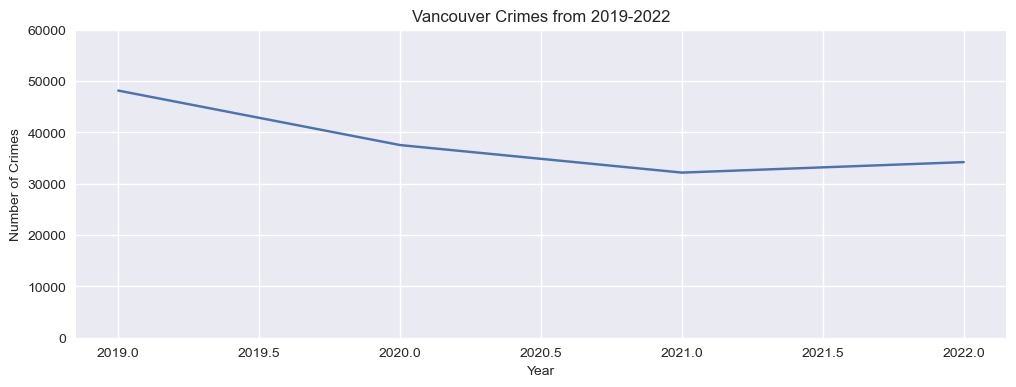

In [16]:
%matplotlib inline
# Setting plot style for all plots
plt.style.use('seaborn')

# Count all crimes and group by year
dfCrimeYear = pd.pivot_table(newdf, values=["Incident"],index = ["YEAR"], aggfunc='count')

# Graph results of Year by Crimes
f, ax = plt.subplots(1,1, figsize = (12, 4), dpi=100)
xdata = dfCrimeYear.index
ydata = dfCrimeYear
ax.plot(xdata, ydata)
ax.set_ylim(ymin=0, ymax=60000)
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Vancouver Crimes from 2019-2022')
plt.show()

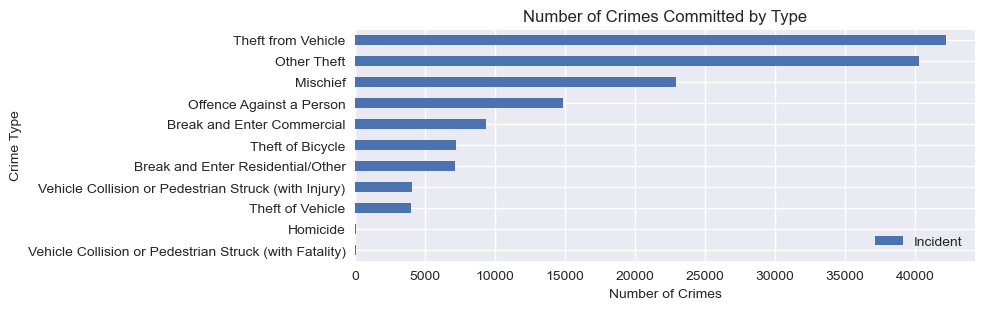

In [17]:
%matplotlib inline
# Pivoting dataframe by Crime Type to calculate Number of Crimes
dfCrimeType = pd.pivot_table(newdf, values=["Incident"],index = ["TYPE"], aggfunc='count')

dfCrimeType = dfCrimeType.sort_values(['Incident'], ascending=True)

# Create bar graph for number of crimes by Type of Crime
crimeplot = dfCrimeType.plot(kind='barh',
               figsize = (8,3),
               title='Number of Crimes Committed by Type'
             )

plt.rcParams["figure.dpi"] = 100
plt.legend(loc='lower right')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.show(crimeplot)

In [18]:
# Calculate total minutes for all rows
total_minutes = newdf['HOUR']*60 + newdf['MINUTE']

# Determine whether time is night or day for all rows
is_night = (total_minutes >= 1260) | (total_minutes < 360)

# Create new column "TIME_OF_DAY" for all rows
newdf['TIME_OF_DAY'] = is_night.map({True: 'night', False: 'day'})


In [19]:
newdf.sample(5)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,NeighbourhoodID,CrimeTypeID,Incident,Date,TIME_OF_DAY
20022,Mischief,2021,7,29,0,16,5XX POWELL ST,Strathcona,493248.0098,5.458932e+06,20.0,4,1,2021-07-29,night
42129,Other Theft,2019,3,9,10,30,22XX CAMBIE ST,Mount Pleasant,491657.2144,5.456953e+06,12.0,6,1,2019-03-09,day
11245,Theft from Vehicle,2020,3,20,0,0,BROUGHTON ST / ROBSON ST,West End,490550.1824,5.459471e+06,23.0,7,1,2020-03-20,night
31862,Other Theft,2022,8,5,22,15,3XX SE MARINE DR,Sunset,492774.6613,5.450883e+06,21.0,6,1,2022-08-05,night
28484,Other Theft,2022,7,3,15,40,21XX LAHB AVE,Arbutus Ridge,488823.3631,5.455084e+06,1.0,6,1,2022-07-03,day


In [20]:
le = LabelEncoder()
newdf['TYPE'] = le.fit_transform(newdf['TYPE'])
newdf['NEIGHBOURHOOD'] = le.fit_transform(newdf['NEIGHBOURHOOD'])


In [21]:
newdf['HUNDRED_BLOCK'] = le.fit_transform(newdf['HUNDRED_BLOCK'])

In [22]:
newdf['TIME_OF_DAY'] = le.fit_transform(newdf['TIME_OF_DAY'])

In [23]:
newdf.sample(5)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,NeighbourhoodID,CrimeTypeID,Incident,Date,TIME_OF_DAY
23649,4,2022,11,15,0,0,13225,1,0.0000,0.000000e+00,2.0,5,1,2022-11-15,1
29114,1,2019,12,21,23,0,8072,3,491518.3614,5.456233e+06,4.0,2,1,2019-12-21,1
15566,1,2022,2,1,19,0,3610,6,495198.1098,5.456426e+06,7.0,2,1,2022-02-01,0
10620,6,2020,1,3,14,55,10149,3,491086.3243,5.456834e+06,4.0,7,1,2020-01-03,0
33103,3,2019,12,6,20,35,7068,1,491759.3721,5.459081e+06,2.0,4,1,2019-12-06,0


In [24]:
newdf.shape

(152049, 15)

In [25]:
from sklearn.linear_model import MultiTaskLasso
from sklearn.preprocessing import StandardScaler
import numpy as np

# Split the data into features (X) and target (y)
X = newdf[['TYPE','YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'NeighbourhoodID', 'CrimeTypeID', 'Incident', 'TIME_OF_DAY']]
y = newdf[['X','Y']]

# Convert categorical variables to one-hot encoding
X = pd.get_dummies(X)

# Standardize the feature values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Fit a multitask Lasso regression model
lasso = MultiTaskLasso(alpha=0.1, max_iter=10000)
lasso.fit(X, y)

# Get the coefficients and feature names
coef = lasso.coef_
feature_names = list(pd.get_dummies(newdf[['TYPE','YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'NeighbourhoodID', 'CrimeTypeID', 'Incident', 'TIME_OF_DAY']]).columns)

# Get the top 10 features with the highest absolute coefficient values for each task
top_features = []
for i, task_name in enumerate(['X', 'Y']):
    task_coef = coef[:,i]
    abs_coef = np.abs(task_coef)
    top_feature_indices = abs_coef.argsort()[::-1][:10]
    top_feature_names = [feature_names[index] for index in top_feature_indices]
    top_features.append((task_name, top_feature_names))

# Print the top features for each task
for task_name, top_feature_names in top_features:
    print(f"Top features for task '{task_name}':")
    for feature_name in top_feature_names:
        print(f"\t{feature_name}")


Top features for task 'X':
	YEAR
	TYPE
Top features for task 'Y':
	YEAR
	TYPE


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:2418: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1593535529898656.0, tolerance: 40398036107242.52
  ) = cd_fast.enet_coordinate_descent_multi_task(


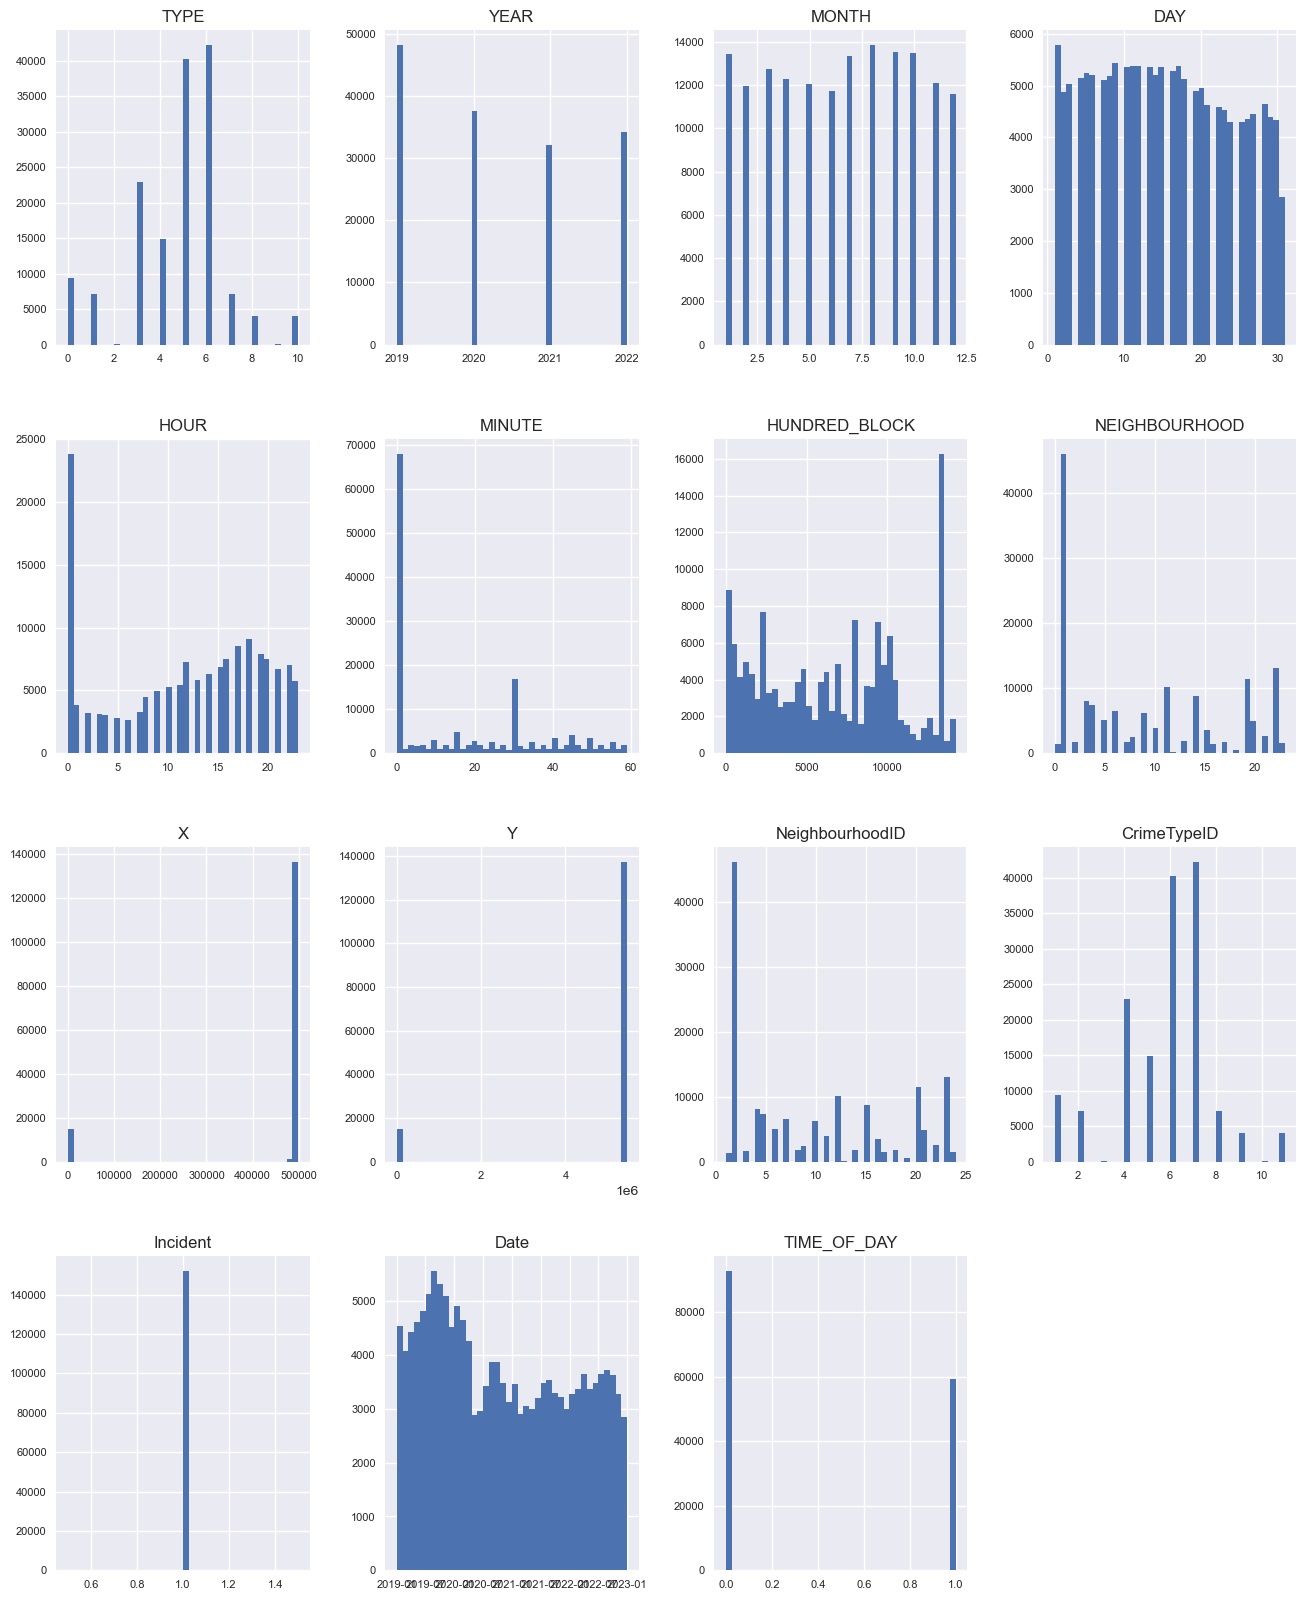

In [26]:
#distribution of all features
newdf.hist(figsize=(16, 20), bins=40, xlabelsize=8, ylabelsize=8);

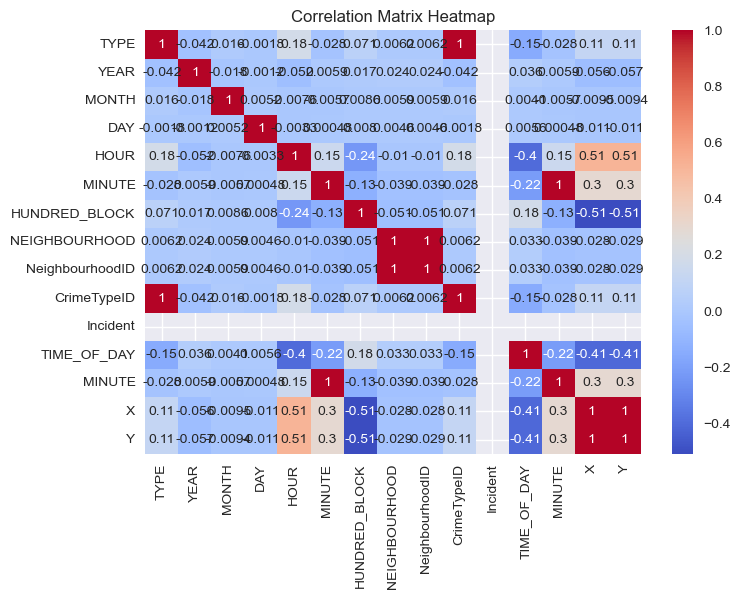

In [27]:
corr_matrix = newdf[['TYPE','YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'NeighbourhoodID', 'CrimeTypeID', 'Incident', 'TIME_OF_DAY', 'MINUTE', 'X', 'Y']].corr()

# create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21336\3303341834.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = newdf.corr()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21336\3303341834.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(corr_x.index, rotation=90)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21336\3303341834.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(corr_y.index, rotation=90)


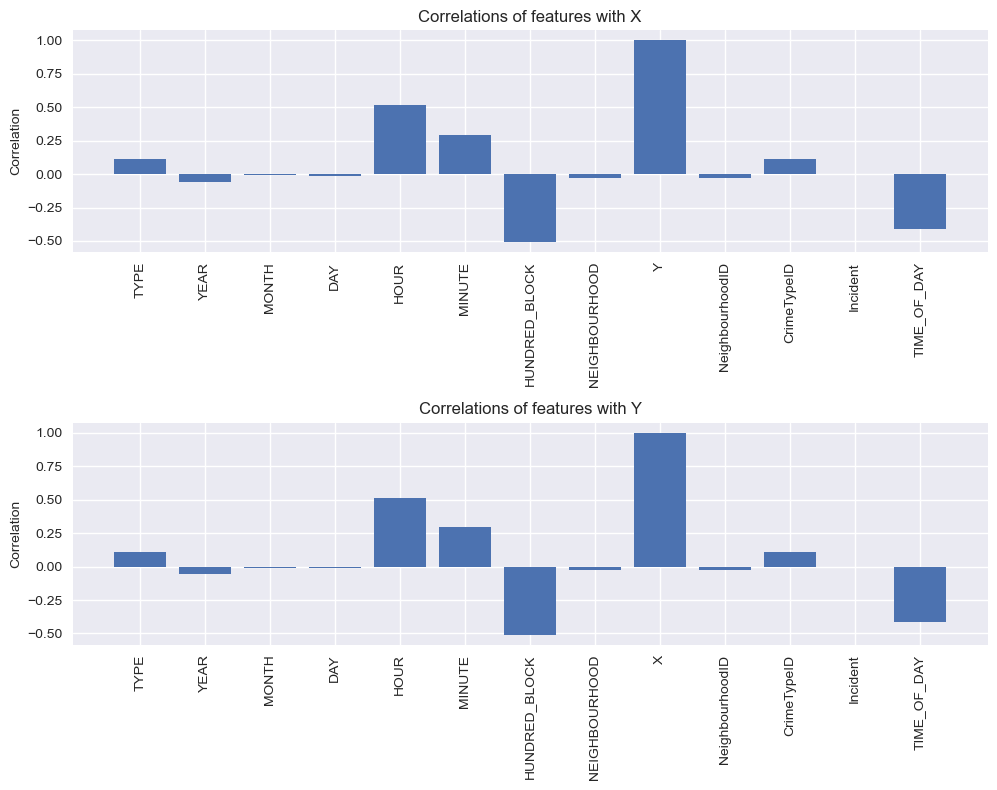

In [28]:
# Compute the correlation matrix
corr_matrix = newdf.corr()

# Select the correlations of X and Y with all other features
corr_x = corr_matrix.loc['X',:].drop('X')
corr_y = corr_matrix.loc['Y',:].drop('Y')

# Create a bar chart for the correlations of X and Y
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

ax[0].bar(corr_x.index, corr_x.values)
ax[0].set_title('Correlations of features with X')
ax[0].set_xticklabels(corr_x.index, rotation=90)
ax[0].set_ylabel('Correlation')

ax[1].bar(corr_y.index, corr_y.values)
ax[1].set_title('Correlations of features with Y')
ax[1].set_xticklabels(corr_y.index, rotation=90)
ax[1].set_ylabel('Correlation')

plt.tight_layout()
plt.show()

In [29]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [30]:
import eli5
from eli5.sklearn import PermutationImportance
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(newdf[['TYPE','YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'NeighbourhoodID', 'CrimeTypeID', 'Incident', 'TIME_OF_DAY']], 
                                                    newdf[['X', 'Y']], 
                                                    test_size=0.2, random_state=42)

# train a linear regression model on the training set
lr_model = LinearRegression().fit(X_train, y_train)

# evaluate feature importance using permutation importance
perm = PermutationImportance(lr_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.3053 ± 0.0053,HUNDRED_BLOCK
0.2027 ± 0.0102,HOUR
0.0583 ± 0.0021,TIME_OF_DAY
0.0535 ± 0.0020,MINUTE
0.0019 ± 0.0003,CrimeTypeID
0.0019 ± 0.0005,TYPE
0.0014 ± 0.0006,YEAR
0.0006 ± 0.0003,NeighbourhoodID
0.0004 ± 0.0001,NEIGHBOURHOOD
0.0000 ± 0.0001,MONTH


In [31]:
#df_theft_from_vehicle.sample()

In [32]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Filter the original DataFrame to include only theft from vehicle crimes
df_theft_from_vehicle = newdf[newdf['TYPE'] == 6]

# 2. Select the top features "TIME_OF_DAY" and "NEIGHBOURHOOD"
features = ['TIME_OF_DAY', 'HUNDRED_BLOCK']

# 3. Split the data into features (X) and target (y)
X = df_theft_from_vehicle[features]
y = df_theft_from_vehicle[['X', 'Y']]

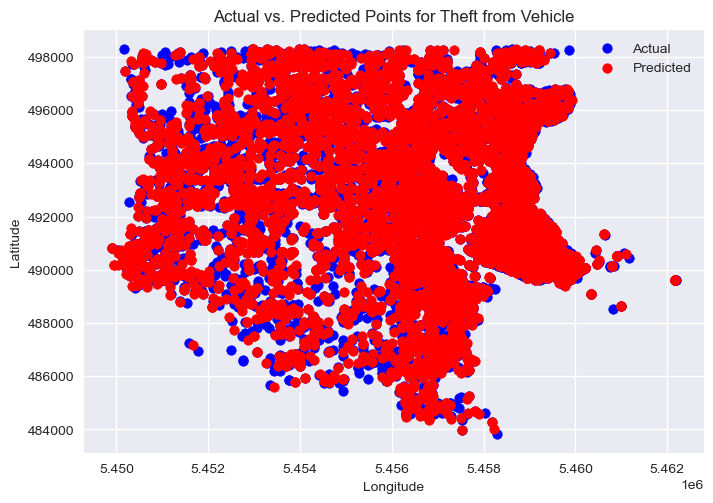

In [33]:


# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train a decision tree regression model on the training data
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# 6. Make predictions on the testing data using the trained model
y_pred = dt.predict(X_test)

# 7. Plot the actual and predicted points on a scatter plot
plt.scatter(y_test['Y'], y_test['X'], color='blue', label='Actual')
plt.scatter(y_pred[:, 1], y_pred[:, 0], color='red', label='Predicted')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs. Predicted Points for Theft from Vehicle')
plt.legend()
plt.show()


In [34]:
# Calculate the accuracy of the model
accuracy = dt.score(X_test, y_test)
print('Accuracy:', accuracy)


Accuracy: 0.8540571689462972


In [35]:
from sklearn.ensemble import RandomForestRegressor

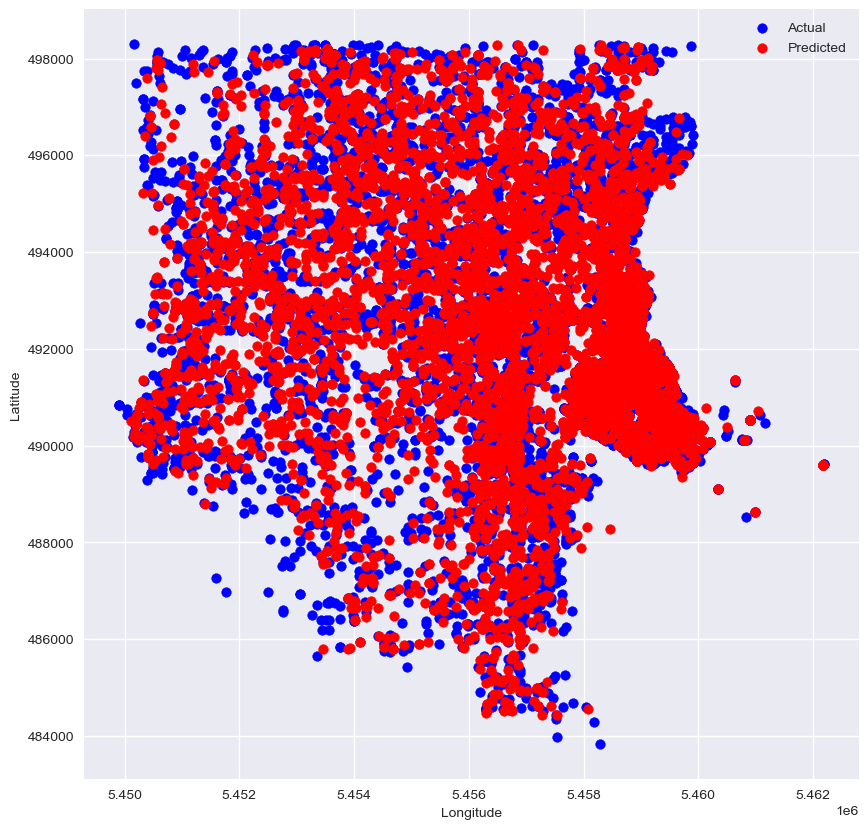

In [36]:
# Create a random forest regression object and fit it to the training data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# Predict the target variables for the testing data
y_pred = rf.predict(X_test)
# Plot the predicted and actual points on a scatter plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(y_test['Y'], y_test['X'], color='blue', label='Actual')
ax.scatter(y_pred[:, 1], y_pred[:, 0], color='red', label='Predicted')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()


In [37]:
from sklearn.metrics import mean_squared_error, r2_score

# Decision Tree
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)
print("Decision Tree Regression Metrics:")
print(f"MSE: {dt_mse}")
print(f"R2 Score: {dt_r2}\n")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
print("Random Forest Regression Metrics:")
print(f"MSE: {rf_mse}")
print(f"R2 Score: {rf_r2}\n")


Decision Tree Regression Metrics:
MSE: 901660.5338072504
R2 Score: 0.8548868865521861

Random Forest Regression Metrics:
MSE: 849478.5940760641
R2 Score: 0.8631552297345633



In [38]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


Epoch 1/100
3802/3802 [==============================] - 15s 4ms/step - loss: 12777200549888.0000 - val_loss: 11094115483648.0000
Epoch 2/100
3802/3802 [==============================] - 13s 3ms/step - loss: 7877312380928.0000 - val_loss: 4781281640448.0000
Epoch 3/100
3802/3802 [==============================] - 16s 4ms/step - loss: 2875280850944.0000 - val_loss: 1469889118208.0000
Epoch 4/100
3802/3802 [==============================] - 12s 3ms/step - loss: 973218578432.0000 - val_loss: 805999607808.0000
Epoch 5/100
3802/3802 [==============================] - 15s 4ms/step - loss: 827999977472.0000 - val_loss: 793074794496.0000
Epoch 6/100
3802/3802 [==============================] - 14s 4ms/step - loss: 815892856832.0000 - val_loss: 780322734080.0000
Epoch 7/100
3802/3802 [==============================] - 16s 4ms/step - loss: 800414695424.0000 - val_loss: 763216658432.0000
Epoch 8/100
3802/3802 [==============================] - 15s 4ms/step - loss: 779488788480.0000 - val_loss: 73

3802/3802 [==============================] - 14s 4ms/step - loss: 152714117120.0000 - val_loss: 150986850304.0000
Epoch 66/100
3802/3802 [==============================] - 12s 3ms/step - loss: 151155867648.0000 - val_loss: 149481979904.0000
Epoch 67/100
3802/3802 [==============================] - 13s 4ms/step - loss: 149668118528.0000 - val_loss: 147845021696.0000
Epoch 68/100
3802/3802 [==============================] - 13s 4ms/step - loss: 148219838464.0000 - val_loss: 146544214016.0000
Epoch 69/100
3802/3802 [==============================] - 13s 4ms/step - loss: 146816958464.0000 - val_loss: 145067130880.0000
Epoch 70/100
3802/3802 [==============================] - 14s 4ms/step - loss: 145474371584.0000 - val_loss: 143621537792.0000
Epoch 71/100
3802/3802 [==============================] - 13s 4ms/step - loss: 144158310400.0000 - val_loss: 142228799488.0000
Epoch 72/100
3802/3802 [==============================] - 802s 211ms/step - loss: 142889975808.0000 - val_loss: 141011992576

Epoch 29/100
3802/3802 [==============================] - 31s 8ms/step - loss: 13491383566336.0000 - val_loss: 13575409106944.0000
Epoch 30/100
3802/3802 [==============================] - 34s 9ms/step - loss: 13490367496192.0000 - val_loss: 13574393036800.0000
Epoch 31/100
3802/3802 [==============================] - 32s 8ms/step - loss: 13489371348992.0000 - val_loss: 13573378015232.0000
Epoch 32/100
3802/3802 [==============================] - 31s 8ms/step - loss: 13488348987392.0000 - val_loss: 13572358799360.0000
Epoch 33/100
3802/3802 [==============================] - 33s 9ms/step - loss: 13487343403008.0000 - val_loss: 13571346923520.0000
Epoch 34/100
3802/3802 [==============================] - 32s 8ms/step - loss: 13486329430016.0000 - val_loss: 13570332950528.0000
Epoch 35/100
3802/3802 [==============================] - 33s 9ms/step - loss: 13485330137088.0000 - val_loss: 13569318977536.0000
Epoch 36/100
3802/3802 [==============================] - 32s 8ms/step - loss: 1348

3802/3802 [==============================] - 29s 8ms/step - loss: 13428940865536.0000 - val_loss: 13512555364352.0000
Epoch 92/100
3802/3802 [==============================] - 33s 9ms/step - loss: 13427904872448.0000 - val_loss: 13511542439936.0000
Epoch 93/100
3802/3802 [==============================] - 30s 8ms/step - loss: 13426911870976.0000 - val_loss: 13510532661248.0000
Epoch 94/100
3802/3802 [==============================] - 34s 9ms/step - loss: 13425896849408.0000 - val_loss: 13509516591104.0000
Epoch 95/100
3802/3802 [==============================] - 35s 9ms/step - loss: 13424922722304.0000 - val_loss: 13508511006720.0000
Epoch 96/100
3802/3802 [==============================] - 29s 8ms/step - loss: 13423891972096.0000 - val_loss: 13507497033728.0000
Epoch 97/100
3802/3802 [==============================] - 29s 8ms/step - loss: 13422882193408.0000 - val_loss: 13506489352192.0000
Epoch 98/100
3802/3802 [==============================] - 29s 8ms/step - loss: 13421879754752.00

array([<Axes: xlabel='Epochs', ylabel='Loss'>,
       <Axes: xlabel='Epochs', ylabel='Loss'>], dtype=object)

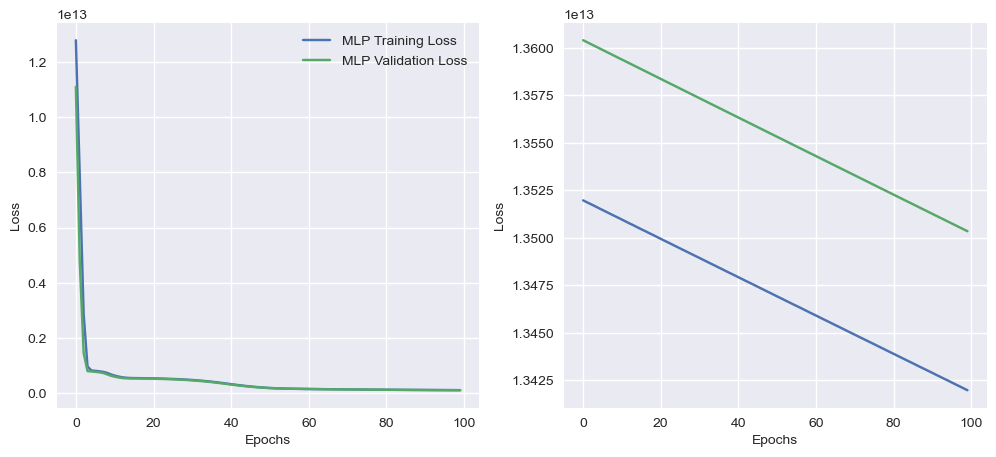

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

# Load the dataset
df = newdf.copy()

# Preprocess the data
X = df[['TIME_OF_DAY', 'HUNDRED_BLOCK']].values
y = df[['X', 'Y']].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Define the MLP model
mlp = Sequential()
mlp.add(Dense(units=64, activation='relu', input_dim=2))
mlp.add(Dense(units=64, activation='relu'))
mlp.add(Dense(units=2))

# Compile the MLP model
mlp.compile(optimizer='adam', loss='mean_squared_error')

# Train the MLP model
history_mlp = mlp.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=10)])

# Define the RNN model
rnn = Sequential()
rnn.add(LSTM(units=64, return_sequences=True, input_shape=(None, 2)))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units=64))
rnn.add(Dense(units=2))

# Compile the RNN model
rnn.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the data for the RNN model
X_train_rnn = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Train the RNN model
history_rnn = rnn.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_data=(X_test_rnn, y_test), callbacks=[EarlyStopping(patience=10)])

# Make predictions using the trained models
y_pred_mlp = mlp.predict(X_test)
y_pred_rnn = rnn.predict(X_test_rnn)

# Compute the performance metrics
from sklearn.metrics import mean_squared_error, r2_score
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
r2_rnn = r2_score(y_test, y_pred_rnn)

# Plot the training and validation losses for both models
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(history_mlp.history['loss'], label='MLP Training Loss')
axes[0].plot(history_mlp.history['val_loss'], label='MLP Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot(history_rnn.history['loss'], label='RNN Training Loss')
axes[1].plot(history_rnn.history['val_loss'], label='RNN Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes


In [41]:
print("mse mlp: ", mse_mlp,"\n",
"R square mlp: ",r2_mlp,"\n",
"mse rnn: ",mse_rnn,"\n",
"R square rnn: ",r2_rnn)

mse mlp:  114476065922.20578 
 R square mlp:  0.9119555052806383 
 mse rnn:  13503455149316.967 
 R square rnn:  -9.241930039431772
